## Exercise set 5: the generalized random forest

In this exercise set we will be working with the [generalized random forest](https://github.com/grf-labs/grf) by Athey et al. The package is written for the R programming language, and while there is a R-to-python interface in [rpy2](https://rpy2.bitbucket.io/) it can be tricky to get working. If you run into trouble, you can consider saving your data to a csv file and work directly in [R](https://www.r-project.org/) through [Rstudio](https://rstudio.com/products/rstudio/download/). 

In [1]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

To highlight the usefulness of GRF we will be working with synthetic data in this exercise. In particular we will synthetically add a treatment effect to a dataset in which there otherwise is none. Furthermore we will make this effect heterogeneous by adding noise, and by making it depend on a single continuous variable as well as a categorical variable. 

>**Ex. 4.1.1:** Complete the code below to simulate data according to
$$
T = U(0,1) > 0.5 \\ 
Y(T=0) = X\beta + \epsilon \\ 
\tau(X) =  \begin{cases}
        \frac{10}{1 + e^{-\gamma X_0}} + \nu & D = 0\\ 
        \nu & D = 1
        \end{cases}\\ 
Y(T=1) = Y(0) + \tau(X) \\ 
$$
where $\epsilon, \nu$ are simply noise terms distributed according to $\mathcal{N}(0,1)$ and $\beta$ is an `N_FEATURES` vector of random parameters. $\gamma$ is a scalar parameter.


In [59]:
N_SAMPLES = 10000
N_FEATURES = 5
GAMMA = 3
BETA = np.random.uniform(0,1, size = N_FEATURES)

X = np.random.normal(size = (N_SAMPLES, N_FEATURES))
D = np.random.choice([0,1], size = N_SAMPLES)

Y0 = X @ BETA + np.random.normal(size = N_SAMPLES)
Tau = 10/(1 + np.exp(-GAMMA*X[:,0]))*(1-D) + np.random.normal(size = N_SAMPLES)
#if D=1 then he first part becomes zero and therefore we only need to specify one tau
Y1 = Y0 + Tau
#we need to define the T as well, same way as the D, but with uniform dist smaller than 0.5:
T = np.random.uniform(0,1, size = N_SAMPLES)> 0.5
y = Y0 + T*(Y1 - Y0)

**Ex. 4.1.2:** Create a two-subplot figure, and plot $Y(0)$ and $Y(1)$ in one subplot against $X_0$. Plot $\tau(x)$ against $X_0$ in the other subplot. What do you see? Why do we observe $\tau=0$ in many cases?

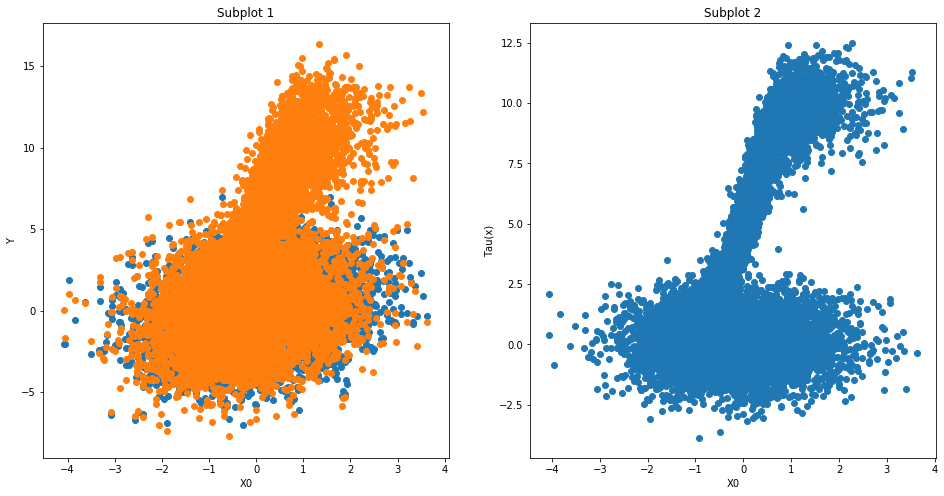

In [60]:
# Subplots 1: Y0 and Y1 against X0. Subplot 2: Tau againts X0.

fig, ax = plt.subplots(1,2, figsize = (16,8))

ax[0].scatter(X[:,0], Y0, label = 'Y(0)')
ax[0].scatter(X[:,0], Y1, label = 'Y(1)')
ax[0].set_title('Subplot 1')
ax[0].set_xlabel('X0')
ax[0].set_ylabel('Y')

ax[1].scatter(X[:,0], Tau, label = 'Tau(x)')
ax[1].set_title('Subplot 2')
ax[1].set_xlabel('X0')
ax[1].set_ylabel('Tau(x)')

plt.show()

#The reason tau is zero in many cases is that when D=0, then the observation are drawn from a distribution with mean 0

>**Ex 4.1.3.** Import `statsmodels` and estimate a simple linear regression
$$
y = \alpha + \delta_0 T + \sum_k \beta_k X_k + \epsilon
$$
>What is your estimate of $\hat{\delta}_0$? How does this number fit with the figures you drew in the previous exercise? Do you have any suggestions for improving the estimate of the model, comment on whether your improvements would provide unbiased estimates of $\tau$? 
>
> **Bonus:** fit your improved model, and relate the parameters you estimate to the figure you plotted in the previous question.

In [61]:
from statsmodels.formula.api import ols

#Using concat to create a dataframe with the variables that we need to estimate the model
#and specifying that it has to be alligned with axis=1. This creates 5 X-variables that correspond with
#the number of feautures.
df = pd.concat([pd.DataFrame(X, columns=[f'X{i}' for i in range(N_FEATURES)]),
                pd.DataFrame(T, columns = ['T']),
                pd.DataFrame(y, columns = ['y'])], axis = 1)

print('The first 5 rows of the dataframe')
print(df.head())

#creating the model, the simple linear regression (SLR), using OLS from sm. 

SLR = ols('y  ~ T + X0 + X1 + X2 + X3 + X4', df)

#fitting the model to improve it

SLRfit = SLR.fit()

print('The fitted model')
print(SLRfit.summary())

The first 5 rows of the dataframe
         X0        X1        X2        X3        X4      T         y
0  0.317639 -0.484141  1.017486  0.072259  0.332953   True  8.606223
1  0.214647 -0.583301 -1.209959 -2.117075 -2.234894   True -4.826310
2 -0.010220  0.917148  1.393048 -0.045886 -0.596133  False  0.990020
3  0.076192 -0.398544  1.310355  1.381706 -2.341980  False  1.069333
4 -0.696033  2.038080  0.621106  2.252698 -0.222638  False  2.460595
The fitted model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1272.
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:50:30   Log-Likelihood:                -24100.
No. Observations:               10000   AIC:                 

>**Ex. 4.1.4:** For this question we will need to move into R (or use rpy2). If you are working in python you can skip this step, otherwise do the following. 
>
> Save a dataframe, containing $X$, $y$, $T$, and $D$ as a csv file on your computer.

In [65]:
# Creating a csv dataframe

#Adding D to my dataframe, that otherwise contains all the data requested
df['D'] = D

#Exporting my data into a csv file

df.to_csv('ex5_konstrueret_data.csv', index = False)



>**Ex. 4.1.5:** Open up R and read the data you just saved into a dataframe(or work in rpy2). Install and load the two libraries `tidyverse` and `grf`.
>
> _Hint:_ to install the required packages. run this:
> ```R
> install.packages("tidyverse")
> install.packages("grf")
> ```

In [72]:
#From the lecture 5 I get the base code for importing R packages into python.
#I install and load tidyverse and grf

# import rpy2's package module
import rpy2.robjects.packages as rpackages
# import R's utility package
utils = rpackages.importr('utils')
# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list
# R package names
packnames = ('tidyverse', 'grf')
# R vector of strings
from rpy2.robjects.vectors import StrVector
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

In [95]:
#Loading more stuff I need, also taken from the lecture

import numpy as np
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects.packages import importr
grf = importr('grf')

C:\Users\barok\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


>**Ex. 4.1.5:** Copy the following code into R to split your dataframe into two matrices, `X`, and `y`. Implement the exact same procedure to create a third matrix `W` which contains the treatment indicator (**Note** `T` is a reserved name in R, so name your third matrix `W`).
>```R
>X <- df %>%
  select(X0, X1, X2, X3, X4, D) %>% 
  as.matrix()
>
>y <- df %>%
  select(y) %>% 
  as.matrix()
>```
> Finally spend some time poking around the [GRF documentation](https://github.com/grf-labs/grf). See if you can figure out how to estimate a GRF model, once you have the three matrices you need (this is way simpler than you might expect).

In [96]:
#Splitting the dataframe into to matrices X and y, using the lecture as inspiration: 

#The lecture that I use for inspiration:
#X_r = ro.r.matrix(X, nrow=n, ncol=p)
#Y_r = ro.r.matrix(Y, nrow=n, ncol=1)
#D_r = ro.r.matrix(D, nrow=n, ncol=1)
#tau_forest = grf.causal_forest(X_r, Y_r, D_r)

#First I need to stack X and D together in order to get the similar "select(X0, X1, X2, X3, X4, D) %>% ", 
print('Array X shape:', X.shape)
print('Array D shape:', D.shape)
#determening i need column stack
X_st = np.column_stack((X,D))

#then proceed in making the two matrices:
X_r = ro.r.matrix(X, nrow=N_SAMPLES, ncol=N_FEATURES)
Y_r = ro.r.matrix(y, nrow=N_SAMPLES, ncol=1)

#Creating W which contains the treatment indicator, where I use T for doing so
W_r = ro.r.matrix(T, nrow=N_SAMPLES, ncol=1)

Array X shape: (10000, 5)
Array D shape: (10000,)


>**Ex.4.1.6:** Estimate a causal forest model using the GRF package, and store the result in a new variable `cf`. Then use the following line to create a dataframe of predicted treatment effects on the same data that you trained the model on. 
>```R
>cf <- # Estimate a generalized RF model aimed at treatment effects.
>tau <- predict(cf, X)
>```
> Once you have your individual treatment effects, run the following line, to save them in a csv file. 
> ```R
> write.csv(tau, "individual_treatment_effects.csv")
> ```

In [140]:
# Estimating the causal forest

cf = grf.causal_forest(X_r, Y_r, W_r)

#prediction inspired by lecture

# lecture 5:
#tau_hat_r = ro.r.predict(tau_forest, X_range)
#tau_hat = pandas2ri.ri2py(tau_hat_r)['predictions'].values

tau_r = ro.r.predict(cf, X_r)


In [141]:
# this does not work: tau_hat = pandas2ri.ri2py(tau_hat_r)['predictions'].values

type(tau_r)

tau = pandas2ri.ri2py(tau_r[0])

type(tau)



numpy.ndarray

In [142]:
tau_df = pd.DataFrame(data=tau)

#numpy_data = np.array([[1, 2], [3, 4]])
#df = pd.DataFrame(data=numpy_data, index=["row1", "row2"]
tau_df

,0
0,3.766713
1,2.984753
2,2.472347
3,2.829689
4,0.471161
...,...
9995,5.130575
9996,0.381572
9997,0.240882
9998,0.101090


In [143]:
tau_df.to_csv('ex5_individual_treatment_effects.csv', index = False)

>**Ex.4.1.6:** This concludes our venture into R. Now load the treatment effects into a pandas dataframe, and plot a scatterplot of the estimated individual treatment effects against the simulated "true" ITE's `Tau` that you produced in the beginning of this exercise set.

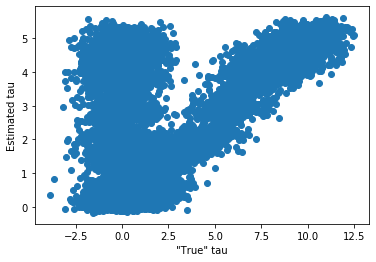

In [146]:
#Scatterplot of the estimated treatment effect (tau) against the "true" Tau.
#It looks like crap and is all wrong.

plt.scatter(Tau, tau)
plt.xlabel('"True" tau')
plt.ylabel("Estimated tau")
plt.show()